In [15]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import missingno as msno
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

In [3]:
df = pd.read_csv("final_unprocessed_data.csv")

In [4]:
cohort = df[(df.RIDAGEYR >= 1) & (df.RIDAGEYR <= 85)]

In [5]:
thresh = len(cohort) * 0.05
cohort = cohort.dropna(thresh=thresh, axis = 1)
thresh2 = 20
cohort = cohort.dropna(thresh=thresh2, axis=0)

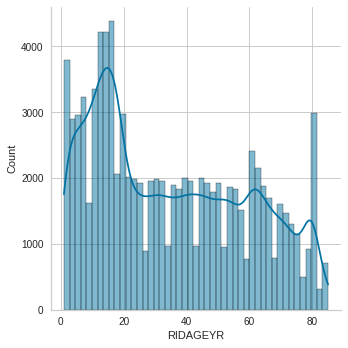

In [6]:
sns.displot(cohort, x="RIDAGEYR", kde=True)

In [7]:
from sklearn.model_selection import train_test_split
y = cohort["RIDAGEYR"]
X = cohort.drop(columns=["RIDAGEYR"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])
X_train = my_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = my_pipeline.transform(X_test)

In [9]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
   {
    'n_estimators': [25, 50, 100, 200, 400,500],
    'max_features': [1, 5, 10, 25, 50, 100],
    'bootstrap': [True, False]
    }
]

forest_reg = RandomForestRegressor()
grid_search = RandomizedSearchCV(forest_reg, param_grid , cv = 5,
                                scoring='neg_mean_squared_error', n_iter=5,
                                n_jobs=-1)
grid_search.fit(X_train, y_train)
f = open("best_params.txt", "w")
f.write(str(grid_search.best_params_))
f.close()

In [10]:
start_time = time.time()
forest_reg = RandomForestRegressor(n_estimators= 100, max_features= 100, bootstrap= False, n_jobs=-1)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features=100, n_jobs=-1)

In [11]:
from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(forest_reg, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
forest_mae_scores = -score
display_scores(forest_mae_scores)

Scores: [4.50891216 4.65644459 4.67814459 4.66011488 4.62902149 4.65318692
 4.72039465 4.65285444 4.71542235 4.7865671 ]
Mean: 4.666106318403145
stdv: 0.06825838538683379


In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, forest_reg.predict(X_test))

0.923629799513125

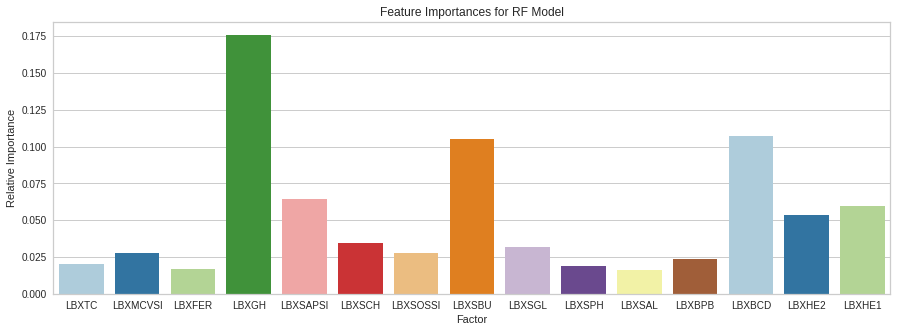

In [13]:
varimp = []
for name, score in zip(X.columns, forest_reg.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');

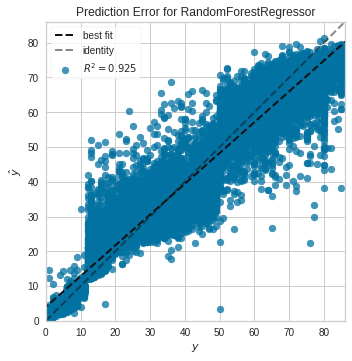

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [14]:
forest_reg = RandomForestRegressor(n_estimators= 100, max_features= 100, bootstrap= False, n_jobs=-1)
visualizer = PredictionError(forest_reg)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

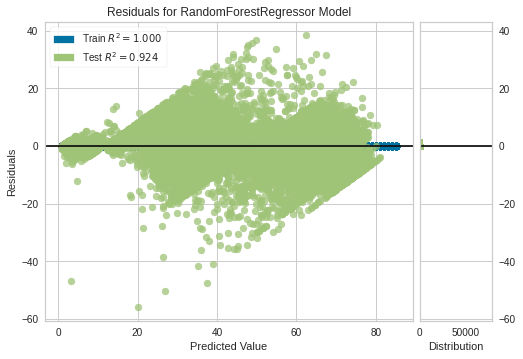

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [16]:
forest_reg = RandomForestRegressor(n_estimators= 100, max_features= 100, bootstrap= False, n_jobs=-1)
visualizer2 = ResidualsPlot(forest_reg)

visualizer2.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer2.score(X_test, y_test)  # Evaluate the model on the test data
visualizer2.show()  